In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28) # -1 for batch size

We can now define a simple CNN

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
    Lambda(mnist_resize),# 1*28*28
    nn.Conv2d(1,8,5, padding=2, stride=2), nn.ReLU(), #8*14*14
    nn.Conv2d(8,16,3, padding=1, stride=2), nn.ReLU(), #16*7*7
    nn.Conv2d(16,32,3, padding=1, stride=2), nn.ReLU(), #32*4*4
    nn.Conv2d(32,32,3, padding=1, stride=2), nn.ReLU(), #32*2*2
    nn.AdaptiveAvgPool2d(1),#32*1*1
    Lambda(flatten),#32*1
    nn.Linear(32, data.c)#10*1
    )

In [11]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.2478596875, tensor(0.1837)]
valid: [2.27039609375, tensor(0.1085)]
CPU times: user 7.42 s, sys: 416 ms, total: 7.83 s
Wall time: 2.8 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [15]:
#Somewhat more flexible way
device = torch.device('cuda',0)# second argument implies which gpu to choose in case of multiple

In [16]:
#device = torch.device('cpu')

In [17]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
        
    # when you begin a batch, we put xb and yb into self.xb and self.yb in the runner class
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)  

In [18]:
# somewhat flexible but quite convenient
torch.cuda.set_device(device)

Don't even need to do the above cell if you've got only one gpu. Now everything by default will be sent to that device
and instead of saying .to(device) we can simply say .cuda()

In [19]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

Instead of saying .to(device) we can just say .cuda(). We're using only 1 gpu in this course.


In [20]:
cbfs.append(CudaCallback)

In [21]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f96c00ffcb0>),
 __main__.CudaCallback]

In [22]:
model = get_cnn_model(data)

In [23]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [2.24819828125, tensor(0.1724, device='cuda:0')]
valid: [2.1994427734375, tensor(0.2353, device='cuda:0')]
train: [1.220971640625, tensor(0.5944, device='cuda:0')]
valid: [0.3439492919921875, tensor(0.8992, device='cuda:0')]
train: [0.30272509765625, tensor(0.9073, device='cuda:0')]
valid: [0.17524476318359375, tensor(0.9494, device='cuda:0')]
CPU times: user 4.85 s, sys: 876 ms, total: 5.73 s
Wall time: 5.1 s


Now, that's definitely faster!  
Can't reuse the model due to the lambda(mnist_resize) so to make it more genralizable we remove it and add it as a callback.


## Refactor model

First we can regroup all the conv/relu in a single function:

In [25]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
    nn.Conv2d(ni,nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a callback. Thus us done so that all of it is more genralizable.

In [26]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
        
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
    
def view_tfm(*size):
    def _inner(x): 
        #print(x.view(*((-1,)+size)).shape)
        return x.view(*((-1,)+size))
    return _inner

In [27]:
mnist_view = view_tfm(1,28,28) # returns a function of size -1,1,28,28; -1 is for the batch_size. It is the same as the the above refactor part.

In [28]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [29]:
nfs = [8,16,32,32]

In [30]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], ks= 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

kernel_size=5,5 for first layer and its 3,3 otherwise.   
*Why is that?*  
no of channels we had in our first layer(o/p)=8
suppose we have a 3x3 kernel so that gives us 9 input activations which are then multiplied with 8x9 matrix to give us a 8x1 output. THis way we're literally just reordering them(started with 9 numbers and ended up with 8).
SO if we make our kernel size=5x5 we'll have 25 inputs for 8 outputs. Imagenet models have a kernel size of 3x7x7(3 is for rgb/colored images) in first conv layer and 32 channels as output. If you have a 3x3x3 kernel instead, it makes for 27 inputs for 32 outputs/channels which is like losing information.

And this helper function will quickly give us everything needed to run the training.

In [31]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func= F.cross_entropy):
    if opt_func is None: opt_func=optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [32]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f96c00ffcb0>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f966855d050>)]

In [33]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [34]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [35]:
run.fit(3, learn)

train: [2.06037546875, tensor(0.2708, device='cuda:0')]
valid: [1.5841224609375, tensor(0.4934, device='cuda:0')]
train: [0.5433663671875, tensor(0.8226, device='cuda:0')]
valid: [0.2590817138671875, tensor(0.9209, device='cuda:0')]
train: [0.22886796875, tensor(0.9324, device='cuda:0')]
valid: [0.16329752197265626, tensor(0.9520, device='cuda:0')]


Now let's look into our model to know how we can train it more quickly, improve accuracy, how do we make it train more stably; we really wanna look inside. How do we find out if its saturating somewhere, if it's too small, if its too big, what's going on? Pytorch hooks is how we do it

## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [36]:
# replacing nn.Sequential with our own SequentialModel class
# only difference is that it contains means and std of the outputs of each layer 
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            #print(x.data.shape)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [37]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [38]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Lambda()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [39]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f96c00ffcb0>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f966855d050>)]

In [40]:
run.fit(2, learn)

train: [1.92070578125, tensor(0.3323, device='cuda:0')]
valid: [0.82844912109375, tensor(0.7328, device='cuda:0')]
train: [0.4062075, tensor(0.8738, device='cuda:0')]
valid: [0.19905731201171875, tensor(0.9404, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

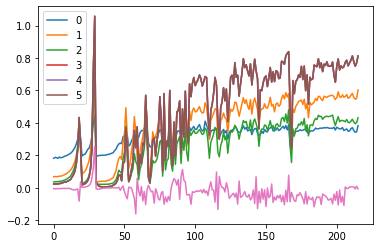

In [41]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

What happens early in training is that for every layer the means of the weights get exponentially bigger until they suddenly collapse and then it happens again it suddenly collapses and so on until eventually it kinda starts training. You might think that its eventually training so that should be okay but jeremy says that his concern is that the part where it falls of a cliff, there are a lot of parameters in our model so ARE WE SURE THAT ALL OF THEM are getting back into resonable places? Maybe the graidents of most of them are zero at this point. We don't know. But it seems very likely that this awful training profile of our model early on is leaving our model in a sad state. That is Jeremy's guess and he goes on to try to prevent this from happening.

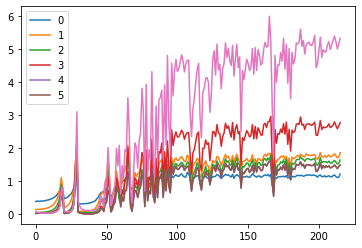

In [42]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

Looking at the first 10 means and stds. (i.e. for the first 10 batches)

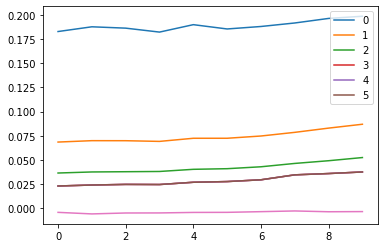

In [43]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

They're pretty close to zero which is what we want. lets look at stds now.

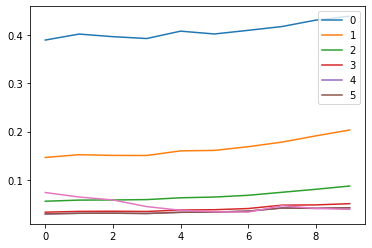

In [44]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

The variance gets further and further away from 1 until the last layer is really close to zero. Our final layers were getting no activations, no gradients and this what we're trying to fix.

This idea of creating telemetry for your model is really vital. But this approach of doing it(writing a whole class to do one kind of telelmetry) is stupid. So the better way to do it is callbacks; except we can't use our callbacks because we don't have one that callbacks to the code when calculating ith layer. Pytorch provides that feature for fwd and bwd passes of our network.

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [45]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [46]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes 3 arguments(module, input, output). Here we store the mean & std of the output in the correct position of our list

In [47]:
def append_stats(i, mod, inp, outp):# i is the layer no, module, input to the module, output of the module
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [48]:
for i, m in enumerate(model):
    # print(f'i:{i}, m={m}')
    m.register_forward_hook(partial(append_stats, i))

From docs: 
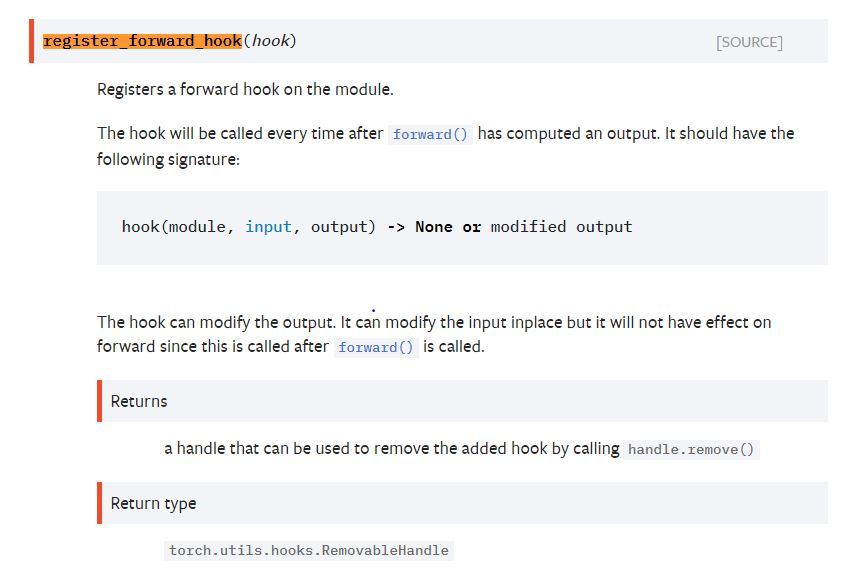

In [49]:
run.fit(1, learn)

train: [2.1647996875, tensor(0.2141, device='cuda:0')]
valid: [1.69254453125, tensor(0.4213, device='cuda:0')]


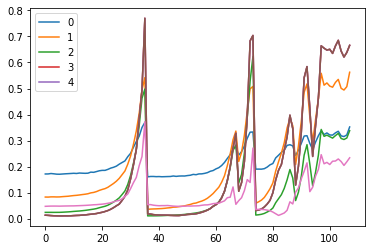

In [50]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

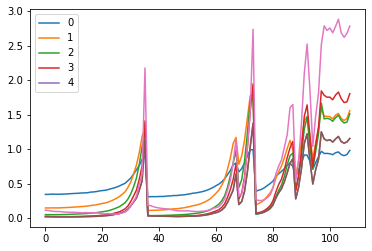

In [51]:
for o in act_stds: plt.plot(o)
plt.legend(range(5))

This is the same thing as above, but it is much more convenient.

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [52]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))# registers a fwd hook on some function f and it recalls back to the object(Hook class).
    # Thus, we passed in self with partial. That way we can get access to the hook from the append_stats fn.
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [53]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [54]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

Just grabbing the first few layers(conv ones) because they are the ones that are the most interesting

In [55]:
run.fit(1, learn)

train: [1.66873828125, tensor(0.4112, device='cuda:0')]
valid: [0.51869033203125, tensor(0.8558, device='cuda:0')]


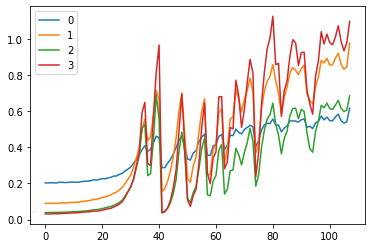

In [56]:
for h in hooks:
    plt.plot(h.stats[0])#means
    h.remove()
plt.legend(range(4))

Refactoring it again as we seem to use this  
hooks = Hook(l, append_stats) for l in children(model[:4])  
lots of times

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.  
We're not allowed to use numpy in foundations so..

In [57]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self) # bool mask--?ANS: see below
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
        
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n {self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [58]:
ListContainer(range(10))

ListContainer (10 items)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [59]:
ListContainer(range(100))

ListContainer (100 items)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [60]:
t = ListContainer(range(10))
t[[1,2]], t[[True]*8 + [False, False]]#ANS

([1, 2], [0, 1, 2, 3, 4, 5, 6, 7])

In [61]:
t[[True]*10] # whatever's true gets selected.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [62]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__(Hook(m, f) for m in ms)
    def __enter__(self, *args): return self 
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()    
        
    def __delitem__(self, i): 
        self[i].remove()
        super().__delitem__(i)
        
    # We're able to go 'for h in self: blah' but we haven't registered any kind of iterator here. 
    # The trick is that we inherit from a ListContainer class. This class has some behaviour of 
    # numpy(we're not allowed to use numpy for our foundations which is why we created it).
    def remove(self):
        for h in self: h.remove()

In [63]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [64]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
 [<__main__.Hook object at 0x7f965d52bb90>, <__main__.Hook object at 0x7f965d4dea50>, <__main__.Hook object at 0x7f965d4de990>, <__main__.Hook object at 0x7f965d737cd0>, <__main__.Hook object at 0x7f965d737510>, <__main__.Hook object at 0x7f965d737490>, <__main__.Hook object at 0x7f965d737050>]

In [65]:
hooks.remove()

In [66]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [67]:
x.mean(), x.std()

(tensor(0.0017, device='cuda:0'), tensor(1.0014, device='cuda:0'))

In [68]:
p = model[0](x) # passing x into fisrt layer of our model(which is a conv2d)
p.mean(), p.std()

(tensor(0.2637, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5046, device='cuda:0', grad_fn=<StdBackward0>))

Ooooooh

In [69]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [70]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4509, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7789, device='cuda:0', grad_fn=<StdBackward0>))

STD improves

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

After initializing our layers of the model with kaiming_normal we plot the means and stds of each layer again.

train: [1.3777515625, tensor(0.5366, device='cuda:0')]
valid: [0.2057365478515625, tensor(0.9380, device='cuda:0')]
train: [nan, tensor(0.5253, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


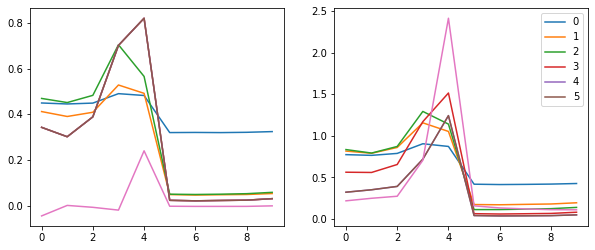

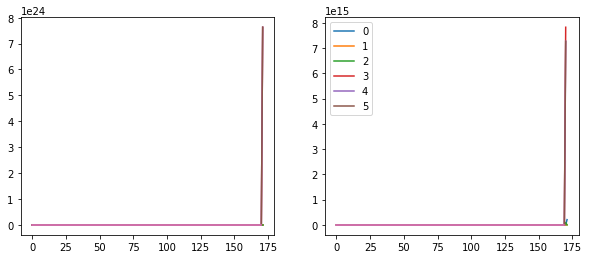

In [71]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    # plotting the first 10 means and stds
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    #plotting all the means and stds
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

As you can see we don't have that exponential crash exponential crash type of curves and stds look close to 1 early on in training.   
This looks hopeful but our concern was to know that does that exponential crash exponential crash and so on do something bad? Is it actually bad or does it train fine afterwards. Bad is about how many of these activations are really really small. So what we could do now is add histograms of our activations to our append_stats and plot them

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [72]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU
    # histogram of the activations, poping them into 40 bins between 0 & 10. 
    # We have a relu so we don't need to go under zero

In [73]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [74]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [75]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.6253159375, tensor(0.4321, device='cuda:0')]
valid: [0.557570361328125, tensor(0.8395, device='cuda:0')]


In [76]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

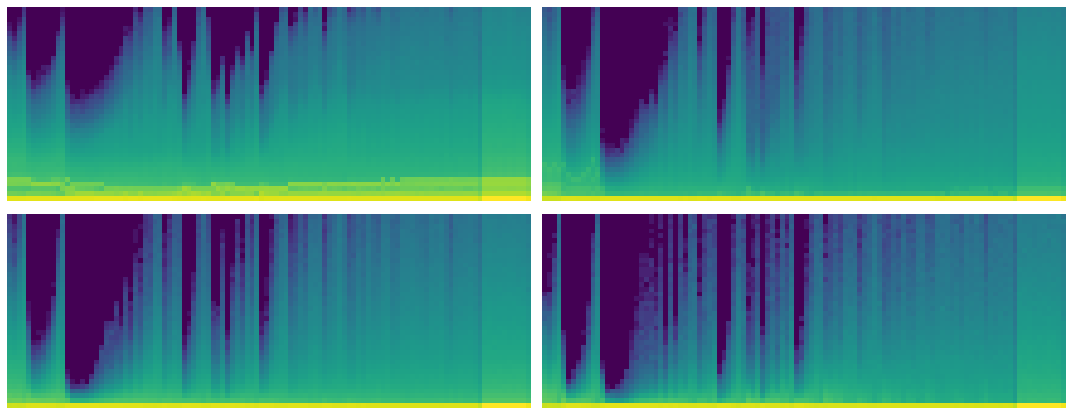

In [77]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

HISTOGRAM EXPLANATION:  
4 histograms for 4 conv layers  
x axis- iterations  
y axis- How many activations are highest they can be or lowest they can be 
So what the graphs show that most of the acivations are close to zero (eg thrid graph, the huge drop part)  
Check out: https://forums.fast.ai/t/the-colorful-dimension/42908  
_yellow denotes the concentration_

We find that even with our kaiming_init if we make our LR really high(=0.9 above) we can still get the same behaviour as above.

From the histograms, we can easily get more informations like the min or max of the activations  
The more yellow the color the more activations are present in that part of the graph

In [78]:
# what % of activations are 0 or nearly 0
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    # (sum of first two histogram bins)/sum(all bins)
    return h1[:2].sum(0)/h1.sum(0)

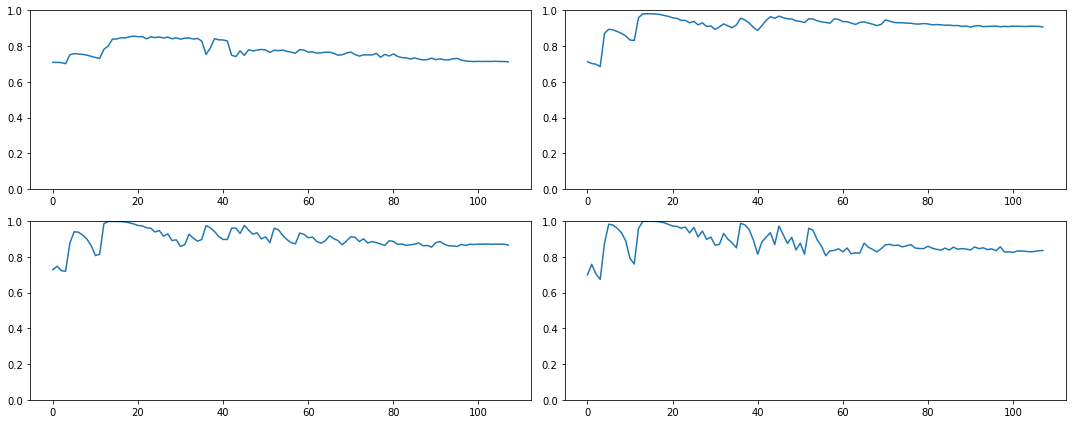

In [79]:
# plotting the % calulated for each of the first 4 layers
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

the curve tells us what % of the activations are zero or nearly zero.

In the last layer, over 90% of your activations are actually zero. So when training like this, it would look like your model is training nicely but 90% of your activations in the fourth layer are totally wasted. You're never gonna get great results this way. Let's fix it and try training at a high LR and not let this happen.  
One of the tricks is to use a better ReLU.

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

slight tweak to all functions defined above where just pass in **kwargs to them so that these variables get passed onto GeneralRelu class in the end

In [80]:
#export
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
    nn.Conv2d(ni,nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

def get_cnn_layers(data, nfs, layer,  **kwargs):
    nfs = [1] + nfs
    return [
        layer(nfs[i], nfs[i+1], ks= 5 if i==0 else 3, **kwargs)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]


def get_cnn_model(data, nfs, layer, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform = False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.01)
            l[0].bias.data.zero_()

In [81]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7,7))# insted of y belonging ot (0, 10) we do (-7,7) now because of leaky ReLU.

In [98]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

We're not doing sub=0.5 anymore like in the previous nbs because we're using leaky relu so we can subtract it by a bit less than half.

train: [0.4486773046875, tensor(0.8592, device='cuda:0')]
valid: [0.135087353515625, tensor(0.9613, device='cuda:0')]
train: [0.127708681640625, tensor(0.9619, device='cuda:0')]
valid: [0.10216234130859375, tensor(0.9713, device='cuda:0')]


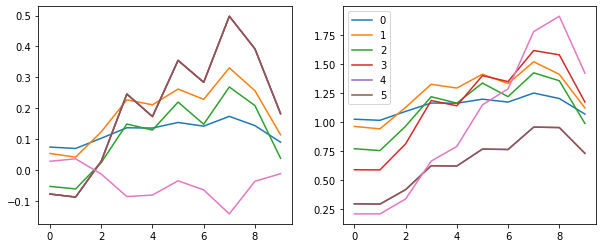

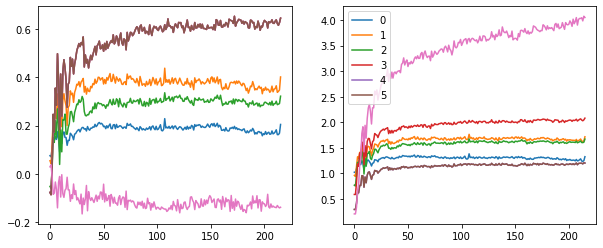

In [99]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    # plotting the first 10 means and stds
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    #plotting all the means and stds
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

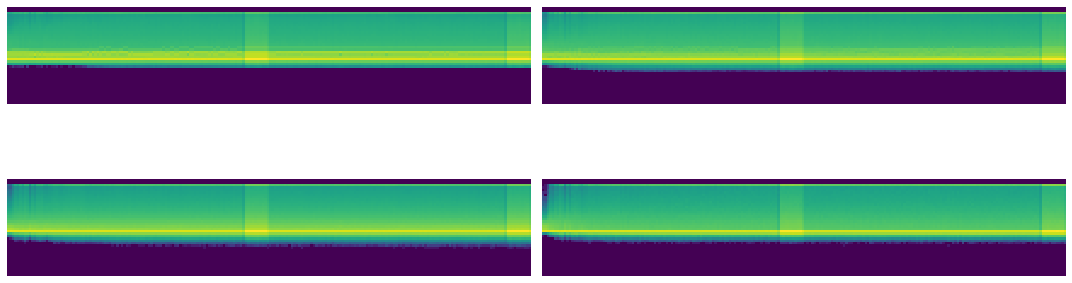

In [100]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

These histograms tell us that most of them are zero(yellow denotes concentration) but there are activations throughout the upper range and a few are a bit less than zero because of leaky relu.

In [101]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

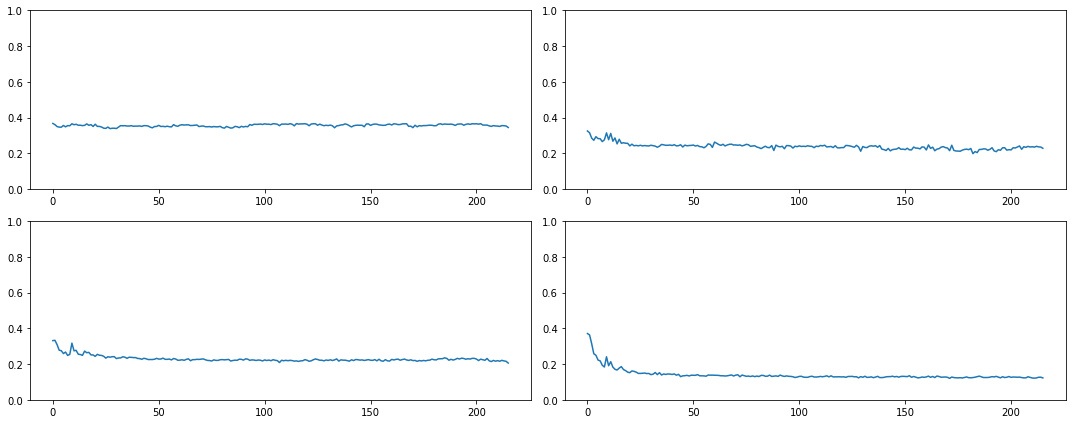

In [102]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

Noicee! less than 20% of the activations are close to zero.

In [87]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

Using one cycle training we created last week

In [88]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [89]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [90]:
run.fit(8, learn)

train: [1.124854765625, tensor(0.6547, device='cuda:0')]
valid: [0.30643916015625, tensor(0.9112, device='cuda:0')]
train: [0.345505546875, tensor(0.8966, device='cuda:0')]
valid: [0.17852774658203124, tensor(0.9467, device='cuda:0')]
train: [0.3423163671875, tensor(0.8981, device='cuda:0')]
valid: [0.1324505126953125, tensor(0.9612, device='cuda:0')]
train: [0.17045962890625, tensor(0.9466, device='cuda:0')]
valid: [0.13762864990234375, tensor(0.9591, device='cuda:0')]
train: [0.128097431640625, tensor(0.9612, device='cuda:0')]
valid: [0.08475306396484375, tensor(0.9754, device='cuda:0')]
train: [0.069082578125, tensor(0.9784, device='cuda:0')]
valid: [0.07000113525390625, tensor(0.9800, device='cuda:0')]
train: [0.0513383984375, tensor(0.9842, device='cuda:0')]
valid: [0.0654968505859375, tensor(0.9826, device='cuda:0')]
train: [0.0425050537109375, tensor(0.9871, device='cuda:0')]
valid: [0.06355206909179688, tensor(0.9828, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [91]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [92]:
run.fit(8, learn)

train: [1.041181015625, tensor(0.6786, device='cuda:0')]
valid: [0.3044892333984375, tensor(0.9133, device='cuda:0')]
train: [0.4523685546875, tensor(0.8680, device='cuda:0')]
valid: [0.70846533203125, tensor(0.8304, device='cuda:0')]
train: [0.2342390234375, tensor(0.9285, device='cuda:0')]
valid: [0.1890730712890625, tensor(0.9437, device='cuda:0')]
train: [0.41557734375, tensor(0.8745, device='cuda:0')]
valid: [2.12846015625, tensor(0.2543, device='cuda:0')]
train: [0.959529921875, tensor(0.6890, device='cuda:0')]
valid: [0.199832275390625, tensor(0.9422, device='cuda:0')]
train: [0.158388662109375, tensor(0.9519, device='cuda:0')]
valid: [0.11189417724609375, tensor(0.9662, device='cuda:0')]
train: [0.098221083984375, tensor(0.9696, device='cuda:0')]
valid: [0.09091950073242187, tensor(0.9731, device='cuda:0')]
train: [0.081684638671875, tensor(0.9748, device='cuda:0')]
valid: [0.08818856201171875, tensor(0.9740, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [103]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [104]:
nb_auto_export()

<IPython.core.display.Javascript object>